In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
import seaborn as sns
from prettytable import PrettyTable

In [196]:
class NeuralNetworks:
    def __init__(self, weights=np.array([0., 0., 0.]), activation_function=lambda x: x):
        self.weights = weights
        self.activation_function = activation_function
        self.df = lambda x: 1
        self.nu = 0.3
        self.border = 0

    def get_net(self, x):
        _x = np.concatenate([[1], x])
        return np.dot(self.weights, _x)

    def predict(self, x):
        predicts = []
        for i in x:
            predicts.append(1 if self.activation_function(self.get_net(i)) >= self.border else 0)
        return predicts

    def fit(self, x, y, epochs=10):
        errors = []
        table = PrettyTable()
        table.field_names = ['k', 'weights', 'y', 'Error']
        t = self.predict(x)
        error = 1 * (t - y)
        error_count = np.count_nonzero(error)
        errors.append(error_count)
        w = np.copy(self.weights)
        table.add_row([0, w, t, error_count])
        for k in range(1, epochs + 1):
            w = np.copy(self.weights)
            for i, el in enumerate(x):
                net = self.get_net(el)
                _df = self.df(net)
                w[0] = w[0] - self.nu * error[i] * _df
                for j in range(1, 3):
                    w[j] = w[j] - self.nu * error[i] * _df * el[j - 1]
            self.weights = w
            t = self.predict(x)
            error = 1 * (t - y)
            error_count_prev = error_count
            error_count = np.count_nonzero(error)
            errors.append(error_count)
            table.add_row([k, w, t, error_count])
        plt.plot(range(1, len(errors) + 1), errors)
        print(table)

In [217]:
# Генерация выборки для класса "Свой"
def generate_own_samples(n):
    x = poisson.rvs(mu=5, size=n)
    y = poisson.rvs(mu=10, size=n)
    return np.column_stack((x, y))


# Генерация выборки для класса "Чужой"
def generate_foreign_samples(n):
    x = norm.rvs(loc=0, scale=5, size=n)
    y = norm.rvs(loc=0, scale=5, size=n)
    return np.column_stack((x, y))


In [218]:
# Визуализация выборок
def plot_samples(own_samples, foreign_samples, thresholds):
    plt.scatter(foreign_samples[:, 0], foreign_samples[:, 1], color='red', label='Чужой')
    plt.scatter(own_samples[:, 0], own_samples[:, 1], color='blue', label='Свой')
    x = np.arange(-15, 16, 15)
    for m, c in thresholds:
        plt.plot(x, m * x + c, linestyle='--')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

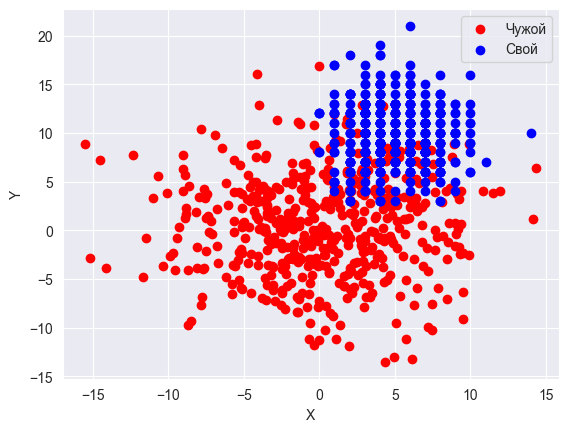

In [219]:
# Генерация выборок
n = 500
own_samples = generate_own_samples(n)
foreign_samples = generate_foreign_samples(n)

plot_samples(own_samples, foreign_samples, [])

In [200]:
def get_train_data(data):
    inds = np.random.choice(len(data), int(0.3 * len(data)))
    train_data = np.array([data[i] for i in inds])
    return train_data

In [201]:
train_x1 = get_train_data(own_samples)
train_x2 = get_train_data(foreign_samples)
train_x = np.concatenate([train_x1, train_x2])
train_y = np.concatenate([np.ones(150), np.zeros(150)])


+-----+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|  k  |                   weights  

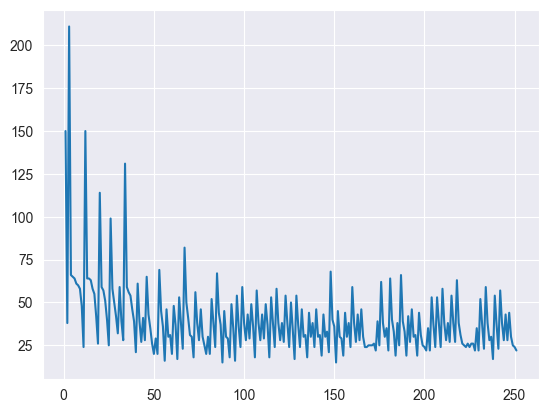

In [202]:
net = NeuralNetworks()
net.fit(train_x, train_y, epochs=250)

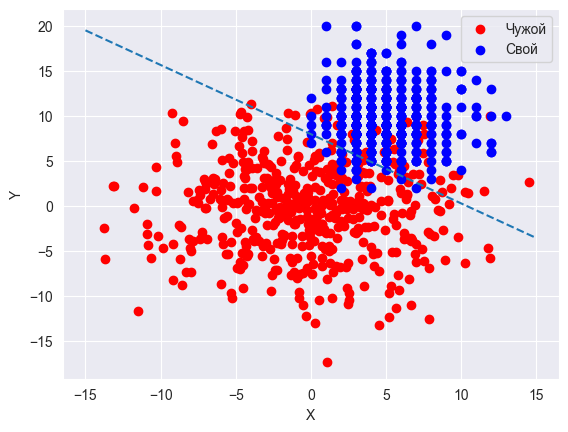

In [203]:
threshold = [-1 * net.weights[1] / net.weights[2], -1 * net.weights[0] / net.weights[2]]
plot_samples(own_samples, foreign_samples, [threshold])

[[451  49]
 [ 23 477]]


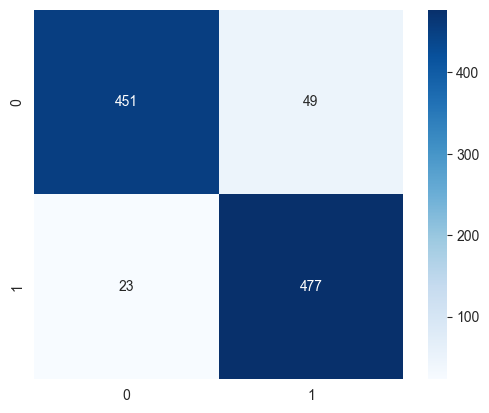

In [204]:
from sklearn import metrics

predictions_own = net.predict(own_samples)

predictions_foreign = net.predict(foreign_samples)
y_actual = np.concatenate([np.ones(n), np.zeros(n)])
y_pred = np.concatenate([predictions_own, predictions_foreign])
conf_mat = metrics.confusion_matrix(y_actual, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, square=True, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.show()

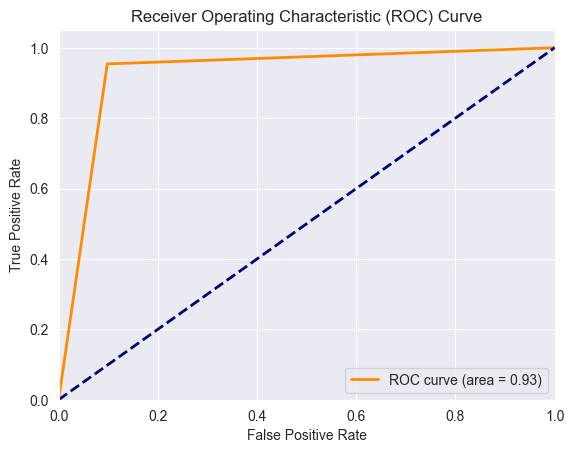

In [205]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_actual, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [206]:
def rotate(points, angle):
    radians = np.radians(angle)
    rotation_matrix = np.array([[np.cos(radians), -np.sin(radians)],
                                [np.sin(radians), np.cos(radians)]])
    print(rotation_matrix)
    rotated_points = np.dot(points, rotation_matrix)
    return rotated_points

[[ 0.8480481  -0.52991926]
 [ 0.52991926  0.8480481 ]]
[[ 0.43837115 -0.89879405]
 [ 0.89879405  0.43837115]]


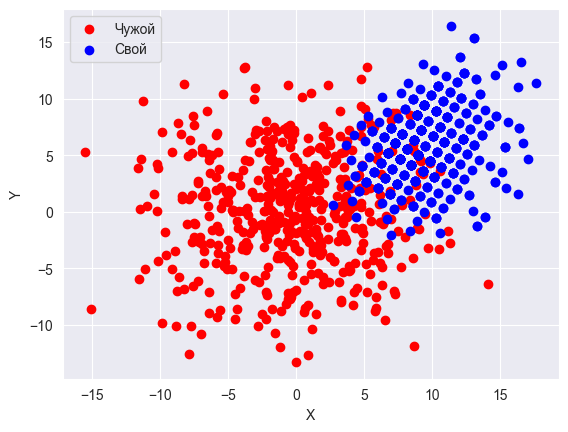

In [207]:
angle1 = 32
angle2 = 64
own_rotate = rotate(own_samples, angle1)
foreign_rotate = rotate(foreign_samples, angle2)
plot_samples(own_rotate, foreign_rotate, [])

+-----+---------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|  k  |                   weights  

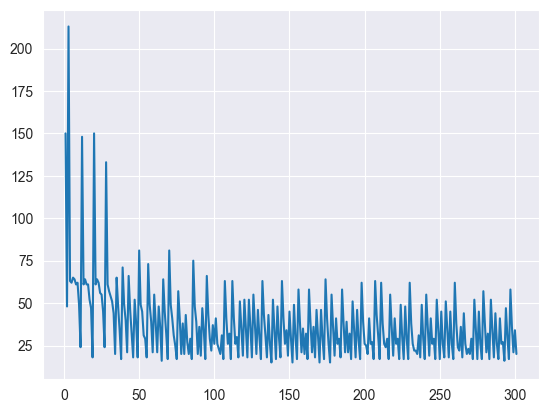

In [210]:
rot_train_x = np.concatenate([get_train_data(own_rotate), get_train_data(foreign_rotate)])
rot_train_y = np.concatenate([np.ones(150), np.zeros(150)])
rot_net = NeuralNetworks()
rot_net.fit(rot_train_x, rot_train_y, 300)

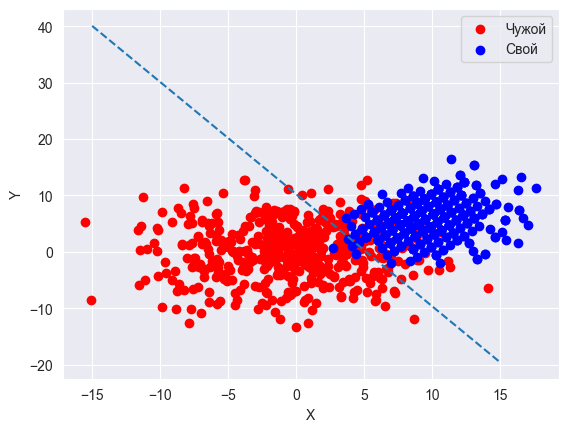

In [211]:
threshold = [-1 * rot_net.weights[1] / rot_net.weights[2], -1 * rot_net.weights[0] / rot_net.weights[2]]
plot_samples(own_rotate, foreign_rotate, [threshold])

[[384 116]
 [  1 499]]


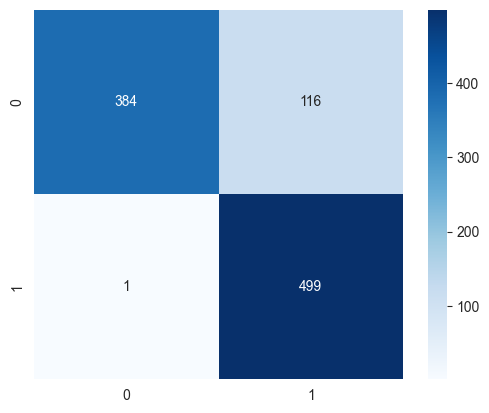

In [212]:
from sklearn import metrics

predictions_own = net.predict(own_rotate)

predictions_foreign = net.predict(foreign_rotate)
y_actual = np.concatenate([np.ones(n), np.zeros(n)])
y_pred = np.concatenate([predictions_own, predictions_foreign])
conf_mat = metrics.confusion_matrix(y_actual, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, square=True, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.show()

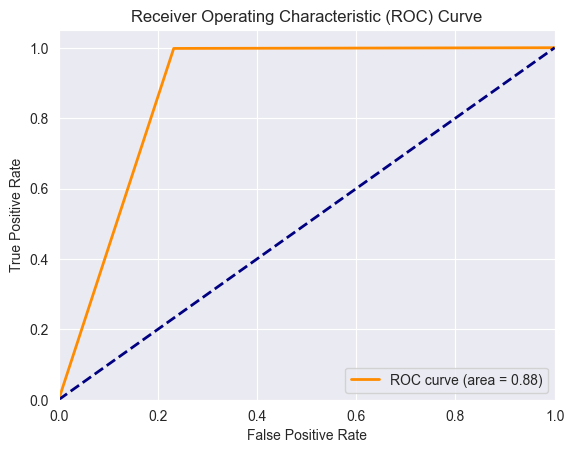

In [213]:
fpr, tpr, _ = roc_curve(y_actual, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()